<center> <img src = https://raw.githubusercontent.com/AndreyRysistov/DatasetsForPandas/main/hh%20label.jpg alt="drawing" style="width:400px;">

# <center> Project: Analysis of Vacancies from HeadHunter 



[see website hh.ru](https://hh.ru/)


In [133]:
import pandas as pd
import psycopg2
import plotly.express as px
from plotly.subplots import make_subplots
import requests
from bs4 import BeautifulSoup
from collections import Counter




import warnings
warnings.filterwarnings("ignore")

import access


In [48]:
connection = psycopg2.connect(
    dbname=access.DBNAME,
    user=access.USER,
    host=access.HOST,
    password=access.PASSWORD,
    port=access.PORT
)

# Preliminary job market analysis

1. First we will count the __number of vacancies__ in our database (_table vacancies_).


In [49]:
# sql query job offers
query_3_1 = f'''
            SELECT * 
            FROM 
                public.vacancies 
'''


In [50]:
# count job offers
df_jobs = pd.read_sql_query(query_3_1, connection)


2.  Next we count the __number of unique employers__ (_table employers_).


In [51]:
#sql query employers
query_3_2 = f'''
            SELECT 
                DISTINCT id
            FROM
                public.employers 
'''


In [52]:
# count unique employers
df_employers = pd.read_sql_query(query_3_2, connection)


3. Then, we count the __number of areas with employment offers__ (_table areas_).

In [53]:
# sql query areas
query_3_3 = f'''SELECT
                    DISTINCT id 
                FROM public.areas
'''

In [54]:
# count unique areas
df_cities = pd.read_sql_query(query_3_3, connection)


4. Finally, we will count the __number of different industries__ in the job database (_table industries_).

In [55]:
# sql query industry type
query_3_4 = f'''SELECT
                    DISTINCT industry_id
                FROM
                    public.employers_industries
'''

In [56]:
# count unique industries
df_industries = pd.read_sql_query(query_3_4, connection)


***

## Preliminary job market analysis results


In [57]:
# Preliminary job market analysis results

print(f'1. Job offers available: {df_jobs.shape[0]}')
print(f'2. Numbers of unique employers: {df_employers.shape[0]}')
print(f'3. Number of areas with job opennings: {df_cities.shape[0]}')
print(f'4. Number of available industries: {df_industries.shape[0]}')

# ответы про юнит 3 лежат здесь в виде кода, потому что ячейка для результатов была ячейкой кода.
# на мой взгляд было бы логичнее выводить ответ на каждый вопрос сразу после результата запроса.


1. Job offers available: 49197
2. Numbers of unique employers: 23501
3. Number of areas with job opennings: 1362
4. Number of available industries: 294


## Preliminary job market analysis revieled the following observations:

1. The number of unique employers accounts for roughly half of the total number of job offers, indicating __an average of two positions offered per employer__. 

2. Job opportunities span across __1362 areas__ and encompass __294 distinct industries__, suggesting extensive coverage within the database. The areas partialy overlap as some indicate the whole country (ex. Russia), while others are names of a city (ex. Moscow), so further data engineereng may be needed to properly deal with the dataset.

# Detailed job market analysis

1. We will begin by writing a query to find out __how many vacancies are there in each area sorted by the number of vacancies in descending order__.

In [58]:
# query jobs per area
query_4_1 = f'''SELECT
                    a.name AS area,
                    COUNT(v.id) AS cnt
                FROM 
                    public.vacancies v
                JOIN
                    public.areas a ON a.id = v.area_id
                GROUP BY 
                    a.id
                ORDER BY 
                    cnt DESC
'''

In [59]:
# count jobs per area
df_jobs_per_area = pd.read_sql_query(query_4_1, connection)

print('Job offers per area')
display(df_jobs_per_area)

Job offers per area


,area,cnt
0,Москва,5333
1,Санкт-Петербург,2851
2,Минск,2112
3,Новосибирск,2006
4,Алматы,1892
...,...,...
764,Кизляр,1
765,Джизак,1
766,Эртиль,1
767,Арсеньев,1


### Visualisation of job offers per area as a treemap (top 50)

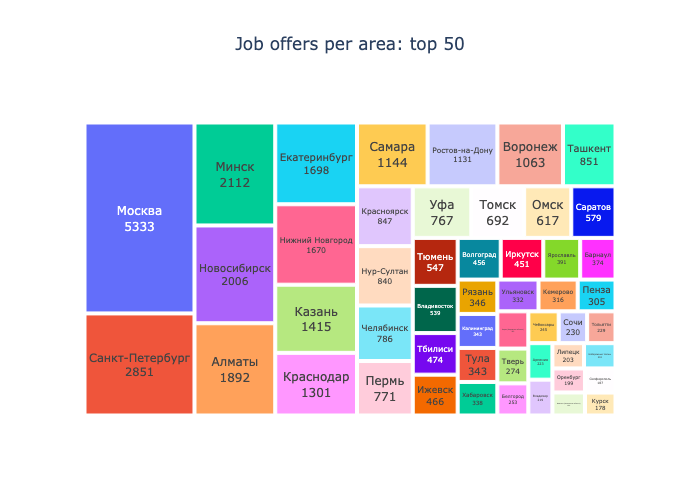

In [60]:
fig = px.treemap(
    data_frame=df_jobs_per_area.head(50),
    path=['area'],
    values='cnt',
    title='Job offers per area: top 50',
    custom_data=['cnt']
).update_layout(
    title={'x':0.5}
)


fig.update_traces(
    hovertemplate='<b>%{label}</b><br>Count: %{customdata[0]}',
    texttemplate='%{label}<br>%{value}',  
    textposition='middle center',  
    textfont_size=12,  
    selector=dict(type='treemap')  
)

fig.show()
fig.show("png")

2. As follows, we will write a query to determine __the number of vacancies where at least one of the two salary fields is filled__.

In [61]:
# sql query salary not NULL
query_4_2 = '''SELECT
                    COUNT(*) AS cnt
                FROM
                    public.vacancies
                WHERE 
                    salary_from IS NOT NULL 
                    OR salary_to IS NOT NULL
'''

In [62]:
# count of jobs with at least one salary field filled in
df_jobs_salary = pd.read_sql_query(query_4_2, connection)

print(f'Number of jobs with salary info filled in: {df_jobs_salary['cnt'].iloc[0]}') # type: ignore

Number of jobs with salary info filled in: 24073


3. Now we will find the __average values for the lower and upper boundaries of the salary range__ and round the values to the nearest integer.

In [63]:
# sql query salary fork
query_4_3 = f'''SELECT 
                    ROUND(AVG(salary_from)) AS mean_salary_from,
                    ROUND(AVG(salary_to)) AS mean_salary_to
                    FROM 
                        public.vacancies
'''                        

In [64]:
# mean lower and upper salary
df_salary_bound = pd.read_sql_query(query_4_3, connection)

print(f'Average salary lower limit: {df_salary_bound['mean_salary_from'].iloc[0]}')
print(f'Average salary upper limit: {df_salary_bound['mean_salary_to'].iloc[0]}')

Average salary lower limit: 71065.0
Average salary upper limit: 110537.0


### Visualisation of salary distribution for mean lower/higher offer as histogram with boxplot

In [65]:
# sql query mean salary
query_4_3_1 = f'''SELECT
                    (salary_from + salary_to) / 2 AS mean_salary
                FROM
                    public.vacancies
'''

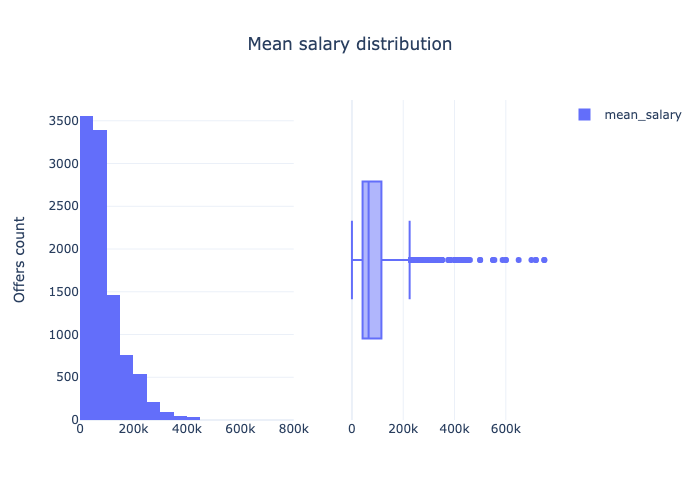

In [66]:
# salary offers data
df_salary = pd.read_sql_query(query_4_3_1, connection)

# set two subplots side by side
fig = make_subplots(rows=1, cols=2)

# add the histogram 
fig.add_trace(
    px.histogram(
        data_frame=df_salary,
        nbins=20,
        labels={'count': 'Offers count', 'value': 'Salary'},
        ).data[0],
        row=1, col=1
    ).update_layout(
        title={'x':0.5},
        template='plotly_white',
        yaxis_title='Offers count',
)
    
# add the box plot 
fig.add_trace(
    px.box(
        data_frame=df_salary,
        x='mean_salary'
    ).data[0],  
    row=1, col=2
)

fig.update_layout(
    title_text='Mean salary distribution',
    title={'x':0.5},
    template='plotly_white'
)


fig.show()
fig.show('png')

4. Now we will output the __number of job offers for each combination of work schedule type__ (schedule) __and employment type__ (employment) used in the vacancies and sort the results by the number of vacancies in __descending order__.

In [67]:
# sql query by work schedule and employment type
query_4_4 = f'''SELECT
                    schedule,
                    employment,
                    COUNT(*) AS cnt
                FROM
                    public.vacancies
                GROUP BY
                    schedule,
                    employment
                ORDER BY
                    cnt DESC
'''

In [68]:
# count jobs combinations
df_schedule_employment = pd.read_sql_query(query_4_4, connection)
df_schedule_employment

,schedule,employment,cnt
0,Полный день,Полная занятость,35367
1,Удаленная работа,Полная занятость,7802
2,Гибкий график,Полная занятость,1593
3,Удаленная работа,Частичная занятость,1312
4,Сменный график,Полная занятость,940
5,Полный день,Стажировка,569
6,Вахтовый метод,Полная занятость,367
7,Полный день,Частичная занятость,347
8,Гибкий график,Частичная занятость,312
9,Полный день,Проектная работа,141


### Visualisation of sschedule/employment type combinations as a heatmap

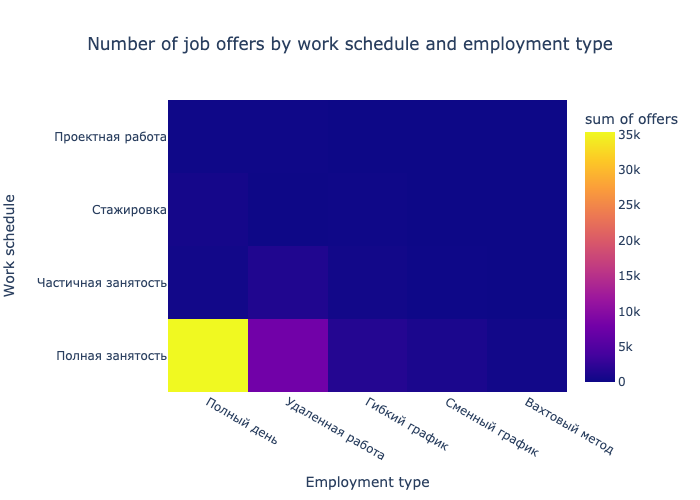

In [69]:
fig = px.density_heatmap(
    data_frame=df_schedule_employment,
    x='schedule',
    y='employment',
    z='cnt',
    title='Number of job offers by work schedule and employment type',
    labels={'cnt': 'offers'},
).update_layout(
    title={'x':0.5},
    yaxis_title='Work schedule',
    xaxis_title='Employment type',
)

fig.show()
fig.show("png")
    


5. Next we output the __amount of jobs with certain 'Required experience'__ (experience) in ascending order.

In [70]:
# sql query required experience
query_4_5 = f'''SELECT 
                    experience,
                    COUNT(*) AS cnt
                FROM 
                    public.vacancies
                GROUP BY 
                    1
                ORDER BY
                    2
'''

In [71]:
# count jobs by requered experience
df_experience = pd.read_sql_query(query_4_5, connection)
df_experience

,experience,cnt
0,Более 6 лет,1337
1,Нет опыта,7197
2,От 3 до 6 лет,14511
3,От 1 года до 3 лет,26152


### Visualisation of job offers by requered experience as a pie chart 

***

In [72]:
# label map
label_map = {
    'Более 6 лет': 'Over 6 years',
    'Нет опыта': 'No experience',
    'От 3 до 6 лет': '3-6 years',
    'От 1 года до 3 лет': '1-3 years'
}

# assign new labels 
new_labels = [label_map[label] if label in label_map else label for label in df_experience['experience']]

# plot the pie chart
fig = px.pie(
    data_frame=df_experience,  
    values='cnt',
    names=new_labels,
    title='Job offers by required experience'
).update_layout(
    title={'x':0.5}
)


fig.show()

### Detailed job market analysis results

In [73]:
# Detailed job market analysis results

# Jobs by areas
sorted_column = df_jobs_per_area['area'].value_counts().sort_values(ascending=False)
top_5_percentage = (sorted_column.head(5).sum() / df_jobs_per_area.shape[0]) * 100
print(f'The top 5 areas by job offers constitute {top_5_percentage:.2f} percent of the total vacancies\n')

# Jobs with salary information, %
salary_info_percentage = (df_jobs_salary['cnt'].iloc[0] / df_jobs.shape[0]) * 100
print(f'Salary information is available for {salary_info_percentage:.2f} percent of jobs\n')

# Schedule and employment type
# full-time employment share
full_time_jobs = df_schedule_employment[df_schedule_employment['employment'] == 'Полная занятость']
total_full_time_jobs = full_time_jobs['cnt'].sum()
percentage_full_time_jobs = (total_full_time_jobs / df_schedule_employment['cnt'].sum()) * 100
print(f'The percentage of jobs with full-time employment is: {percentage_full_time_jobs:.2f}%\n')

# full_time on-site jobs
full_time_full_day = full_time_jobs[full_time_jobs['schedule'] == 'Полный день']
total_full_time_full_day = full_time_full_day['cnt'].sum()
percentage_full_day_full_time = (total_full_time_full_day / total_full_time_jobs) * 100
print(f'Out of the full-time jobs, {percentage_full_day_full_time:.2f}% are on-site\n')

# top 3 schedule/employment type combinations
top_3 = df_schedule_employment.head(3)
print(f'Top 3 combinations are:')
display(top_3)

# Required experience
total_jobs = df_experience['cnt'].sum()
df_experience['percentage'] = round((df_experience['cnt'] / total_jobs) * 100, 2)
print('Experience requerements, %')
display(df_experience)



The top 5 areas by job offers constitute 0.65 percent of the total vacancies

Salary information is available for 48.93 percent of jobs

The percentage of jobs with full-time employment is: 93.64%

Out of the full-time jobs, 76.77% are on-site

Top 3 combinations are:


,schedule,employment,cnt
0,Полный день,Полная занятость,35367
1,Удаленная работа,Полная занятость,7802
2,Гибкий график,Полная занятость,1593


Experience requerements, %


,experience,cnt,percentage
0,Более 6 лет,1337,2.72
1,Нет опыта,7197,14.63
2,От 3 до 6 лет,14511,29.50
3,От 1 года до 3 лет,26152,53.16


### Detailed Job Market Analysis Revealed Key Trends:

1. The dataset encompasses __job vacancies not only within Russia but also in neighboring countries__ like Belarus and Kazakhstan. Among the top 5 areas by the number of vacancies, __Moscow leads with 5333__ job offers, followed by __Saint Petersburg with 2851__, __Minsk with 2112__, __Novosibirsk with 2006__, and finally __Almaty with 1892__ openings.

2. A mere __49% of job postings provide information regarding the offered salary__. Analysis of the mean salary distribution via a boxplot suggests that proposed __salaries typically range between 41,500 to 115,000 rubles__, with a __median value of 65,000 rubles__. Although plausible, the presence of potential outliers with salaries exceeding 650,000 rubles requires further analysis to ensure data accuracy.

3. __Full-time employment dominates the job market__, constituting approximately __94%__ of all jobs, with roughly __77% of these positions requiring on-site presence__. The most common schedule/employment type combination is full-time on-site employment, comprising 35,367 vacancies, followed by full-time remote work with 7,802 offers, and a minimal 1,593 offers for full-time flexible hours.

4. __The majority of job postings (over 53%)  require 1-3 years of experience__, while nearly __30% seek candidates with 3-6 years of experience__. Approximately __15% of vacancies are for candidates with no prior experience__, while those with __over 6 years of experience are needed for less than 3%__ of positions. The low demand for experienced professionals may originate from employers preferring to hire mid-level employees with foundational industry knowledge, but still adaptable to the hiring company's specific approaches. Another explanation is a higher retention rate among high-level employees, which results in less job openings. The natural low amount of requered senor specialists is another factor. Finally,  it is also possible that recruitment for senor positions is carried out through networking rather than via open channels.

# Employer analysis

1. We will start with a query to find out which employers rank first and fifth in terms of the number of job vacancies.

In [74]:
# sql query for job offers per employer
query_5_1 = f'''SELECT
                    e.name AS employer,
                    COUNT(v.id) as jobs
                FROM 
                    public.employers e
                JOIN 
                    public.vacancies v ON e.id = v.employer_id
                GROUP BY 
                    1
                ORDER BY
                    2 DESC
'''

In [75]:
# top 5 employers by number of job offers
df_employers = pd.read_sql_query(query_5_1, connection)
print(f'Job offers per employer, top 10:')
df_employers.head(10)

Job offers per employer, top 10:


,employer,jobs
0,Яндекс,1933
1,Ростелеком,491
2,Тинькофф,444
3,СБЕР,428
4,Газпром нефть,331
5,ИК СИБИНТЕК,327
6,МТС,292
7,DataArt,247
8,Совкомбанк Технологии,204
9,Первый Бит,176


### Visualisation of employer ranking by job offers as a bar graph (top 10)

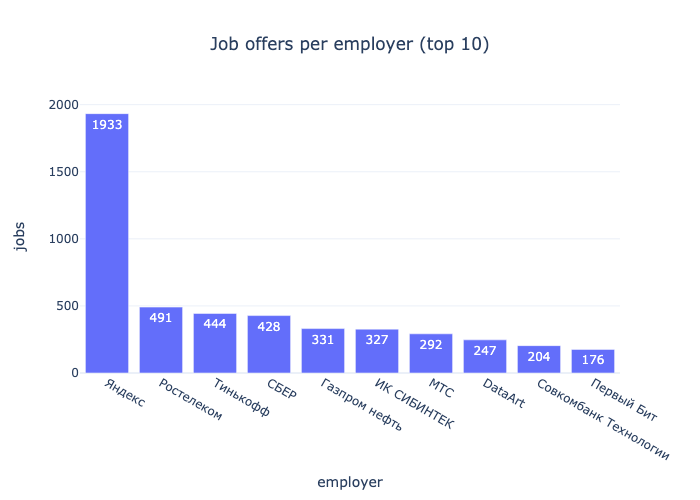

In [76]:
fig = px.bar(
    data_frame=df_employers.head(10),
    x='employer',
    y='jobs',
    title='Job offers per employer (top 10)',
    text_auto=True
).update_layout(
    title={'x':0.5},
    template='plotly_white'
)

fig.show()
fig.show('png')

2. Now we will output the number of employers and job offers for each area. As follows, among the areas with no vacancies, we will find the one with the highest number of employers.

In [77]:

#sql query employers in the cities with no job offers
query_5_2_2 = f'''SELECT 
                    a.name AS area,
                    COUNT(DISTINCT e.id) AS total_employers
                FROM 
                    public.areas a
                JOIN 
                    public.employers e ON a.id = e.area
                LEFT JOIN 
                    public.vacancies v ON a.id = v.area_id
                WHERE 
                    v.id IS NULL
                GROUP BY 
                    1
                ORDER BY
                    2 DESC
                LIMIT 1;
'''

In [78]:

# find the city with no vacancies with the most biggest number of employers
df_no_jobs = pd.read_sql_query(query_5_2_2, connection)
print(f'The area with no job offers with the biggest amount of employers is {df_no_jobs['area'].iloc[0]}')
print(f'The amount of employers in {df_no_jobs['area'].iloc[0]} is {df_no_jobs['total_employers'].iloc[0]} ')


The area with no job offers with the biggest amount of employers is Россия
The amount of employers in Россия is 410 


### Visualisation of the number of employers per area as a bar chart

In [79]:
# sql query employers and jobs per city
query_5_2 = '''SELECT 
                    a.name AS area,
                    COUNT(DISTINCT e.id) AS total_employers
                FROM
                    public.areas a
                LEFT JOIN
                    public.employers e ON a.id = e.area
                GROUP BY
                    a.name
                ORDER BY
                    total_employers DESC
                LIMIT
                    10;
'''

In [80]:
# count employers and job offers per city
df_employers_area = pd.read_sql_query(query_5_2, connection)

print("Top 10 areas with the highest number of employers:")
df_employers_area

Top 10 areas with the highest number of employers:


,area,total_employers
0,Москва,5864
1,Санкт-Петербург,2217
2,Минск,1115
3,Алматы,721
4,Екатеринбург,609
5,Новосибирск,573
6,Казань,480
7,Нижний Новгород,426
8,Россия,410
9,Краснодар,409


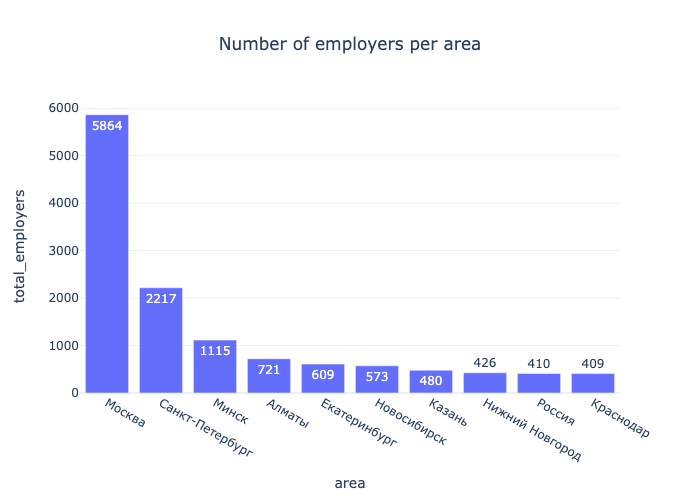

In [81]:
fig = px.bar(
    data_frame=df_employers_area,
    x='area',
    y='total_employers',
    title='Number of employers per area',
    text_auto=True
).update_layout(
    title={'x':0.5},
    template='plotly_white'
)

fig.show()
fig.show('png')

3. For each employer, we will calculate the number of areas where they publish their vacancies and sort the result by the number of areas in descending order.

In [82]:
# sql query employers' offers by area
query_5_3 = f'''SELECT 
                    e.name AS employer,
                    COUNT(DISTINCT v.area_id) AS total_areas
                FROM 
                    public.employers e
                JOIN
                    public.vacancies v ON e.id =v.employer_id
                GROUP BY 
                    e.id
                ORDER BY
                    2 DESC
'''

In [83]:
# employers by areas with job offers
df_employers_areas = pd.read_sql_query(query_5_3, connection)
print('Number of areas where each employer is hiring:')
display(df_employers_areas)

Number of areas where each employer is hiring:


,employer,total_areas
0,Яндекс,181
1,Ростелеком,152
2,Спецремонт,116
3,Поляков Денис Иванович,88
4,ООО ЕФИН,71
...,...,...
14901,НПП Авиатрон,1
14902,Центр дистанционных торгов,1
14903,Городские Телекоммуникационные Системы,1
14904,"Введенский, Отель",1


### Visualisation of job offers per area by employers as a bar chart

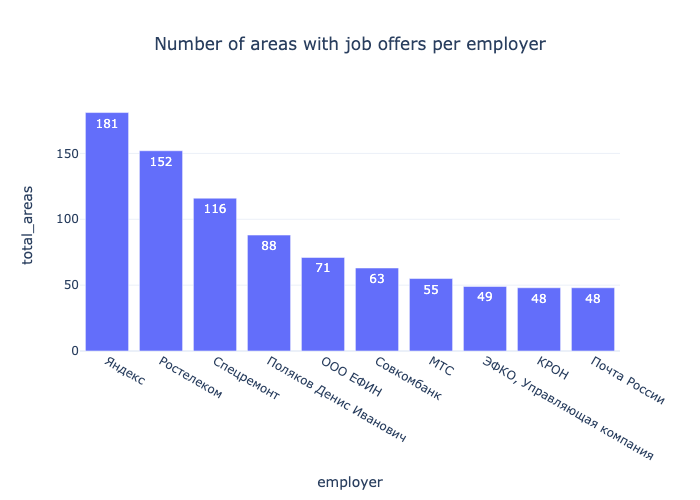

In [84]:
fig = px.bar(
    data_frame=df_employers_areas.head(10),
    x='employer',
    y='total_areas',
    title='Number of areas with job offers per employer',
    text_auto=True
).update_layout(
    title={'x':0.5},
    template='plotly_white'
)

fig.show()
fig.show('png')

4. Our next step is to count the number of employers who have not specified their field of activity.

In [91]:
# sql query no industry info
query_5_4 = f'''SELECT 
                    COUNT(*) AS cnt
                FROM 
                    public.employers e
                LEFT JOIN
                    public.employers_industries ei ON e.id = ei.employer_id
                WHERE
                    ei.industry_id IS NULL
'''

In [92]:
# count employers with no industry info
df_no_industry = pd.read_sql_query(query_5_4, connection)
print(f'Number of employers without industry information: {df_no_industry['cnt'].iloc[0]}')

Number of employers without industry information: 8419


5. Next is a query to find the name of the company ranked third in the alphabetical list (by name) of companies that have specified four fields of activity.


In [ ]:
# sql query companies with 4 industries
query_5_5 = f'''SELECT
                    e.name as employer
                FROM
                    public.employers e 
                JOIN
                    public.employers_industries ei ON e.id = ei.employer_id
                GROUP BY
                    e.id
                HAVING
                    COUNT(DISTINCT ei.industry_id) = 4
                ORDER BY
                    e.name 
'''

In [ ]:
# third company in the list of employers with 4 industries
df_4_industries = pd.read_sql_query(query_5_5, connection)
print(f'The third company in the list of employers hiring in 4 fields of activity: {df_4_industries['employer'].iloc[2]}')


The third company in the list of employers hiring in 4 fields of activity: 2ГИС


6. Now we will determine the number of employers whose field of activity is specified as Software Development ('Разработка программного обеспечения').

In [88]:
# sql query softwear development employers
query_5_6 = f'''SELECT 
                    COUNT(*) as cnt 
                FROM 
                    employers e
                JOIN
                    employers_industries ei ON e.id = ei.employer_id
                JOIN
                    industries i ON ei.industry_id = i.id
                WHERE i.name = 'Разработка программного обеспечения'
'''
                

In [89]:
# total SWD companies
df_swd = pd.read_sql_query(query_5_6, connection)
print(f'Total amount of companies hiring in Software Development: {df_swd['cnt'].iloc[0]}')

Total amount of companies hiring in Software Development: 3553


7. For the company "Yandex," we will display a list of million-plus cities where the company is hiring, along with the total number of jobs in this company. We will sort the result by the number of job offers in ascending order.

[million-plus cities](https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D1%80%D0%BE%D0%B4%D0%B0-%D0%BC%D0%B8%D0%BB%D0%BB%D0%B8%D0%BE%D0%BD%D0%B5%D1%80%D1%8B_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8) 

In [ ]:
million_plus_cities = []

url = 'https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D1%80%D0%BE%D0%B4%D0%B0-%D0%BC%D0%B8%D0%BB%D0%BB%D0%B8%D0%BE%D0%BD%D0%B5%D1%80%D1%8B_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8'

response = requests.get(url)
page = BeautifulSoup(response.text, 'html.parser')
for tr in page.find_all('tbody')[0].find_all('tr')[1:]:
    city_name = tr.find('a').text.strip()
    million_plus_cities.append(city_name)
print("List of million-plus cities in Russia:")
for city in million_plus_cities:
    print(city)



List of million-plus cities in Russia:
Москва
Санкт-Петербург
Новосибирск
Екатеринбург
Казань
Красноярск
Нижний Новгород
Челябинск
Уфа
Самара
Ростов-на-Дону
Краснодар
Омск
Воронеж
Пермь
Волгоград


In [ ]:
# sql query yandex jobs in million-plus cities
query_5_7 = f'''SELECT 
                    a.name AS city,
                    COUNT(*) AS total_jobs
                FROM
                    areas a
                JOIN
                    vacancies v ON a.id = v.area_id
                JOIN
                    employers e ON e.id = v.employer_id
                WHERE
                    e.name = 'Яндекс'
                    AND a.name IN ('{'\', \''.join(million_plus_cities)}')
                GROUP BY 
                    a.id
                UNION
                SELECT
                    'Total',
                    COUNT(*)
                FROM
                    areas a
                JOIN
                    vacancies v ON a.id = v.area_id
                JOIN
                    employers e ON e.id = v.employer_id
                WHERE
                    e.name = 'Яндекс'
                    AND a.name IN ('{'\', \''.join(million_plus_cities)}')
                ORDER BY
                    2
'''

In [ ]:
# df

df_yandex = pd.read_sql_query(query_5_7, connection)

print('Yandex job openings in the million-plus cities:')
display(df_yandex)


Yandex job openings in the million-plus cities:


,city,total_jobs
0,Омск,21
1,Челябинск,22
2,Красноярск,23
3,Волгоград,24
4,Пермь,25
5,Казань,25
6,Ростов-на-Дону,25
7,Уфа,26
8,Самара,26
9,Краснодар,30


***

In [101]:
# Employer analysis results
print(f'Median jobs top 10 employers: {df_employers['jobs'].head(5).median()}\n')
print('Employers that offer jobs in most areas:')
display(df_employers_areas.head(10))
print(f'Percentage of empoyers with unspecifyed industry: {round((df_swd['cnt'].iloc[0] / df_no_industry['cnt'].iloc[0]) * 100,2)}\n') 
print(f'Percentage of empoyers hiring in software development: {round((df_swd['cnt'].iloc[0] / df_jobs.shape[0]) * 100, 2)}')

Median jobs top 10 employers: 444.0

Employers that offer jobs in most areas:


,employer,total_areas
0,Яндекс,181
1,Ростелеком,152
2,Спецремонт,116
3,Поляков Денис Иванович,88
4,ООО ЕФИН,71
5,Совкомбанк,63
6,МТС,55
7,"ЭФКО, Управляющая компания",49
8,КРОН,48
9,Почта России,48


Percentage of empoyers with unspecifyed industry: 42.2

Percentage of empoyers hiring in software development: 7.22


# Employer analysis results

1. As mentioned above, the average employer typically offers two job openings at once. However, __the leading employer, Yandex, stands out with nearly 2000 openings__, while the __median number of job offers among the top 10 employers is 444__.

2. Further analysis has uncovered __multiple areas with no job openings__, despite having registered employers. Notably, __Moscow leads with 5864 job offers__, followed by __Saint Petersburg with 2217 openings__, and __Minsk with 1115 jobs__. The remaining areas have fewer than 1000 open vacancies.

3. Large companies often extend their job offerings across various regions, with __Yandex leading by covering 181 areas__.

4. Approximately __30% of employers omit specifying their industry__. Implementing a mandatory field for industry specification on the hh.ru platform could enhance search efficiency for both job seekers and employers.

5. __Software development accounts for approximately 7% of job offerings__ among employers.

6. __Yandex apears to be the  top employer__ not only in terms of the number of job openings but also in the breadth of its hiring across million-plus cities throughout Russia. This suggests that Yandex's recruitment strategy is geared towards attracting candidates from across the country rather than solely focusing on the capital city.

# Data science or data analyst jobs analysis

Further on we will consider that the job is in data science jobs if the title contains at least one of the following combinations:

* 'data scientist'
* 'data science'
* 'исследователь данных' (Russian equivalent of 'data scientist')
* 'ML' (excluding HTML-related vacancies)
* 'machine learning'
* 'машинн%обучен%' (Russian equivalent of 'machine learning')

1. First, we will find out how many job offers are related to data (contain words 'data' или 'данн' written in any case ).

In [102]:
# query to retrieve jobs with 'data' or 'данн'

query_6_1 = f'''
    SELECT
        COUNT(*)
    FROM
        public.vacancies
    WHERE
        LOWER(name) LIKE '%data%'
        OR LOWER(name) LIKE '%данн%'
'''

In [106]:
# 
df_data_jobs = pd.read_sql_query(query_6_1, connection)
display(f'Number of job openings related to data: {df_data_jobs['count'].iloc[0]}')


'Number of job openings related to data: 1771'

2. Then, we will the number of suitable jobs for a beginner data scientist, assuming that the job title contains the word 'junior' or required experience is 'No experience' or employment type is 'Internship'.

In [107]:
# query jobs for beginner data scientists
query_6_2 = f'''
    SELECT
        COUNT(*)
    FROM
        public.vacancies
    WHERE
        (
            LOWER(name) LIKE '%data scientist%'
            OR LOWER(name) LIKE '%data science%'
            OR LOWER(name) LIKE '%исследователь данных%'
            OR LOWER(name) LIKE '%ml%' AND LOWER(name) NOT LIKE '%html%'
            OR LOWER(name) LIKE '%machine learning%'
            OR LOWER(name) LIKE '%машинн%обучен%%'
        )
        AND (
            LOWER(name) LIKE '%junior%'
            OR experience = 'Нет опыта'
            OR employment = 'Стажировка'
        )
'''

In [110]:
# number of begginer data scientist jobs
df_jun_ds = pd.read_sql_query(query_6_2, connection)
print(f'Number of job openings for a junior data scientist: {df_jun_ds['count'].iloc[0]}')

Number of job openings for a junior data scientist: 51


3. Now will count the jobs for data scientists where SQL or PostgreSQL is specified as a key skill.


In [111]:
# query jobs with SQL or PostgreSQL
query_6_3 = f'''
    SELECT
        COUNT(*)
    FROM
        public.vacancies
    WHERE
        (
            LOWER(name) LIKE '%data scientist%'
            OR LOWER(name) LIKE '%data science%'
            OR LOWER(name) LIKE '%исследователь данных%'
            OR LOWER(name) LIKE '%ml%' AND LOWER(name) NOT LIKE '%html%'
            OR LOWER(name) LIKE '%machine learning%'
            OR LOWER(name) LIKE '%машинн%обучен%%'
        )
        AND (
            key_skills LIKE '%SQL%'
            OR key_skills LIKE '%postgres%'
        ) 
'''

In [114]:
# number of jobs with SQL or PostgreSQL
df_sql = pd.read_sql_query(query_6_3, connection)
print(f'Number of data science jobs with key skill SQL or PostgreSQL: {df_sql['count'].iloc[0]}')


Number of data science jobs with key skill SQL or PostgreSQL: 229


4. As follows, we will count the data scence jobs with Python required as a key skill.

In [115]:
# query jobs with Python
query_6_4 = f'''
    SELECT
        COUNT(*)
    FROM
        public.vacancies
    WHERE
        (
            LOWER(name) LIKE '%data scientist%'
            OR LOWER(name) LIKE '%data science%'
            OR LOWER(name) LIKE '%исследователь данных%'
            OR LOWER(name) LIKE '%ml%' AND LOWER(name) NOT LIKE '%html%'
            OR LOWER(name) LIKE '%machine learning%'
            OR LOWER(name) LIKE '%машинн%обучен%%'
        )
        AND (
            lower(key_skills) LIKE '%python%'
        ) 
'''

In [116]:
# number of jobs with Python
df_python = pd.read_sql_query(query_6_4, connection)
print(f'Number of data science job jobs with key skill Python: {df_python['count'].iloc[0]}')

Number of data science job jobs with key skill Python: 357


5. Next we will find out how many key skills, on average, are specified in job offers for data scientists, rounded to two decimals.

In [117]:
# query key skills for data scientists
query_6_5 = f'''
    SELECT
        ROUND(AVG(CARDINALITY(STRING_TO_ARRAY(key_skills, '\t'))), 2) AS avg_skills
    FROM
        public.vacancies
    WHERE
        (
            LOWER(name) LIKE '%data scientist%'
            OR LOWER(name) LIKE '%data science%'
            OR LOWER(name) LIKE '%исследователь данных%'
            OR name LIKE '%ML%' AND name NOT LIKE '%HTML%'
            OR LOWER(name) LIKE '%machine learning%'
            OR LOWER(name) LIKE '%машинн%обучен%%'
        )        
'''

In [119]:
# average number of key skills for a data scentist
df_key_skillsp = pd.read_sql_query(query_6_5, connection)
print(f'Average number of key skills for data scientists: {df_key_skillsp['avg_skills'].iloc[0]}')

Average number of key skills for data scientists: 6.41


6. Next up is  to calculate the average salary for data scientists for each type of required experience (unique value from the experience field).

We will only consider  vacancies where at least one of the two salary fields is filled.
If both salary fields are filled, we will use the mean value. 
To avoid getting null in our results we will use the coalesce function, which replaces null with the value we provide. 

Finaly, we will determine the average salary that a data scientist with 3 to 6 years of experience can expect, rounded to the nearest integer.

In [120]:
# query avarage DS salary
query_6_6 = '''
    SELECT
        experience,
        ROUND(AVG(CASE
            WHEN salary_from IS NOT NULL AND salary_to IS NOT NULL
                THEN (salary_from + salary_to) / 2
            ELSE COALESCE(salary_from, 0) + COALESCE(salary_to, 0)
        END)) AS salary
    FROM
        public.vacancies
    WHERE
        (
            LOWER(name) LIKE '%data scientist%'
            OR LOWER(name) LIKE '%data science%'
            OR LOWER(name) LIKE '%исследователь данных%'
            OR name LIKE '%ML%' AND name NOT LIKE '%HTML%'
            OR LOWER(name) LIKE '%machine learning%'
            OR LOWER(name) LIKE '%машинн%обучен%%'
        )
        AND (
            salary_from IS NOT NULL
            OR salary_to IS NOT NULL
        )
    GROUP BY
        experience
'''


In [121]:
# average salary for DS jobs with different experience level
df_ds_experience = pd.read_sql_query(query_6_6, connection)
display('Average salaries for DS jobs for by level of experience:')
df_ds_experience

'Average salaries for DS jobs for by level of experience:'

,experience,salary
0,Нет опыта,74643.0
1,От 1 года до 3 лет,139675.0
2,От 3 до 6 лет,243115.0


### Visualisation of salary expectation for data scientists by experience level as a bar chart

***

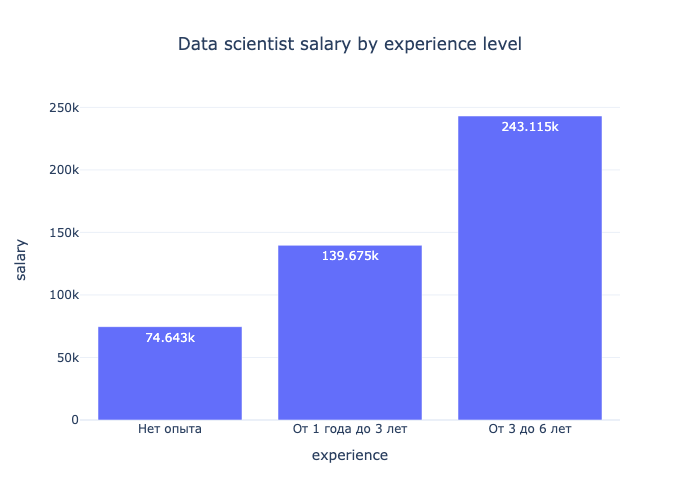

In [125]:
fig = px.bar(
    df_ds_experience, 
    x='experience', 
    y='salary', 
    title='Data scientist salary by experience level',
    text_auto=True
).update_layout(
    title={'x':0.5},
    template='plotly_white'
)
    
fig.show()
fig.show('png')


In [132]:
# data science jobs analysis results
print(f'Persantage of data sience jobs: {round((df_data_jobs['count'].iloc[0] / df_jobs.shape[0]) * 100, 2)}')
print(f'Persantage of data science jobs in software development: {round((df_data_jobs['count'].iloc[0] / df_swd['cnt'].iloc[0]) * 100, 2)}')
print(f'Persantage of entry-level data science positions: {round((df_jun_ds['count'].iloc[0] / df_data_jobs['count'].iloc[0]) * 100, 2)}')

Persantage of data sience jobs: 3.6
Persantage of data science jobs in software development: 49.85
Persantage of entry-level data science positions: 2.88


### Data science jobs analysis results

1. __3.6% of available positions are for data scientists__. To assess the significance of this figure, it should be contextualized by comparing it to historical trends and the distribution of job opportunities across other professions. However, the data suggests a strong demand for data scientists, as __they constitute approximately 50% of all job openings in the software development__ industry.

2. Only __2.9% of employers seeking data scientists are willing to hire inexperienced candidates__, indicating a high barrier to entry into the industry. An effective strategy for candidates may involve starting their careers as interns to gain valuable experience before pursuing full-time employment.

3. On average, a __data scientist is expected to possess 6.41 key skills__. Out of 1771 job listings, __229 require knowledge of SQL or PostgreSQL, and 357 require proficiency in Python__, highlighting the relative importance of these skills in the data science field. Further analysis is necessary to identify the essential skills that enhance candidates' prospects of employment.

4. The mean expected salaries for data scientists progress from __74,643 rubles for inexperienced professionals__ to __139,675 rubles for those with 1-3 years of experience__, and finally to __243,115 rubles for individuals with 3-6 years of industry experience__. This substantial increase in salary (tripple) after just three years in the field makes data science an attractive career option for individuals considering their future prospects. These salary figures could be compared to those of other professions to gain a better understanding of the profession's attractiveness in the Russian job market.



# Additional analysis suggested in the previos section

7.1 

We will find which industry offers the most opportunities for employment and compare the results with those for data scientists

In [138]:
# query most attractive industries
query_7_1 = f'''SELECT 
                    i.name AS industry,
                    COUNT(*) AS total_jobs
                FROM 
                    public.vacancies v
                LEFT JOIN
                    employers_industries ei ON v.employer_id = ei.employer_id
                LEFT JOIN
                    public.industries i ON ei.industry_id = i.id
                GROUP BY 
                    i.name
                ORDER BY 
                    total_jobs DESC
                LIMIT 
                    1
'''


In [155]:
# the top industry by job offers
df_top_industry = pd.read_sql_query(query_7_1, connection)
print(f'The industry with most job opportunities')
display(df_top_industry)
print(f'Persantage of software development jobs: {round((df_top_industry['total_jobs'].iloc[0] / df_jobs.shape[0]) * 100, 2)}')

The industry with most job opportunities


,industry,total_jobs
0,Разработка программного обеспечения,12499


Persantage of software development jobs: 25.41


7.2

We will map the skills requered to work as a data scientists and rank them by their popularity among the employers.

In [134]:
# query key skills for data scientists
query_7_2 = f'''
    SELECT
        STRING_TO_ARRAY(key_skills, '\t') AS skills
    FROM
        public.vacancies
    WHERE
        (
            LOWER(name) LIKE '%data scientist%'
            OR LOWER(name) LIKE '%data science%'
            OR LOWER(name) LIKE '%исследователь данных%'
            OR name LIKE '%ML%' AND name NOT LIKE '%HTML%'
            OR LOWER(name) LIKE '%machine learning%'
            OR LOWER(name) LIKE '%машинн%обучен%%'
        )
        AND key_skills IS NOT NULL
'''

In [144]:
# key skills for data scientists
skills = []
df_skills = pd.read_sql_query(query_7_2, connection)

# list of key skills for data scientists
for index, row in df_skills.iterrows():
    skills.extend(row["skills"])

# demand for each skill
count = Counter(skills)
print('Key skills for  data science:')
count.most_common(10)

Key skills for  data science:


[('Python', 348),
 ('SQL', 191),
 ('Machine Learning', 114),
 ('Git', 66),
 ('Математическая статистика', 62),
 ('Data Analysis', 54),
 ('Data Science', 52),
 ('Pandas', 52),
 ('ML', 49),
 ('Английский язык', 48)]

### Visualisation of data science key skills as a tree map

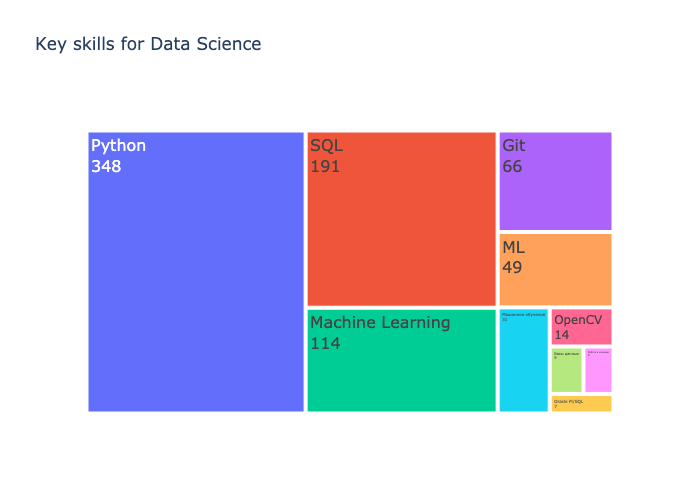

In [154]:
# convert Counter to list of tuples
skills_list = list(count.items())

# create DataFrame
df_skills = pd.DataFrame(skills_list, columns=['skill', 'count'])

# plot a treemap
fig = px.treemap(
    df_skills.head(10), 
    path=['skill'], 
    values='count', 
    title='Key skills for Data Science',
)

for index, row in df_skills.head(10).iterrows():
    fig.data[0].textinfo = 'label+value'
    fig.update_traces(textfont_size=16)
    
fig.show()
fig.show('png')

### NOTE 

Three of the skills displayed on the treemap, namely "Machine Learning", "ML" and "Машинное обучение" actually refer to the same skill set. When combined, they account for a total of 194 requests, which places  "Machine Learning" above SQL in key skills ranking, outranked only be expertise in Python.

7.3 

Finally, we will compare the mean salary for an experienced data scientist (3-6 years) with the top salary across industries for workers with the same experience level. Additionally, we will identify which profession offers the highest salary expectation after three years of industry experience. 

These comparisons will provide valuable insights into the relative earning potential of data scientists compared to professionals in other fields, as well as highlight lucrative career paths for individuals seeking to maximize their earning potential.

In [141]:
# query top salary for candidates with 3-6 years of experience
query_7_3 = f'''SELECT 
                    i.name,
                    MAX(salary_to) AS top_salary
                FROM 
                    public.vacancies v
                LEFT JOIN
                    employers_industries ei ON v.employer_id = ei.employer_id
                LEFT JOIN
                    public.industries i ON ei.industry_id = i.id
                WHERE 
                    experience = 'От 3 до 6 лет' -- Filter for 3-6 years of experience
                    AND salary_to IS NOT NULL -- Ensure salary information is available
                GROUP BY 
                    1
                ORDER BY 
                    2 DESC
                LIMIT 
                    1
'''


In [142]:
# top industry by salary for candudates with 3-6 years of experience
df_top_salary = pd.read_sql_query(query_7_3, connection)
print(f'The industry with highest salary for experienced candidates:')
display(df_top_salary)


The industry with highest salary for experienced candidates:


,name,top_salary
0,Разработка программного обеспечения,1000000


# Overall results
1. The hh.ru platform offers a comprehensive search across numerous geografic  areas and industries, providing extensive information about employers, jobs, and employees to enhance the efficiency of candidate-to-job matching. Employers on the platform range from small to large, offering candidates a wide array of options.
2. The largest employer on the platform is Yandex, providing a multitude of employment opportunities across extensive geographic areas and hiring in all major cities.
3. The most sought-after career path for job seekers appears to be software development. Despite only 7% of employers indicating they hire in this industry, 25% of the platform's postings are for software developers. Furthermore, this profession promises the highest pay, with an average of 1,000,000 rubles after only three years of industry experience.
4. Despite the great amount on IT jobs, the hh.ru platform also offers a variety of vacancies unrelated to software development, constituting 75% of the total job offers.
5. Data scientists are in demand for 1771 positions, while the overall demand for software development is 12499, meaning that data science specialists account for 14% of the most employable industry.
6. Data science presents a promising career choice with a rapid salary growth trajectory within the first three years of employment. However, the mean salary for experienced data science professionals is only around 25% of the top salary promised for the same experience level in software development, standing at 243,115 rubles for data science and 1,000,000 rubles for software development.
7. Entering the data science profession may be challenging due to a lack of employers seeking inexperienced candidates (only about 3%). Key skills for a data science specialist include Python, Machine Learning, SQL, Git, and OpenCV, most of which are covered by the current data science course at Skillfactory.ru, indicating that the programme equips data scientists candidates with the necessary skills for employability.


# Further analysis revenues

The data set provides data for the following lines of analysis:

1. __Geographical Analysis:__ Further investigation into job offers and employer distributions across different regions or cities can reveal geographic patterns in employment opportunities and regional variations in job market dynamics.

2. __Industry Analysis:__ Deeper analysis of specific industries can provide a better understanding of the  demand for different skill sets, salary trends, and emerging positions.

3. __Skill Set Analysis:__ Analyzing the demand for various skills and/or their combinations across different job roles can help identify key skills in high demand and inform educational and training decisions for the job-seekers.

Additionally, the data from the hh.ru platform might be a source for trend analysis across geographical regions, industries, and skill sets over a historical timeframe, offering invaluable insights into labor market dynamics. Conducting such analysis will require a comprehensive dataset spanning a selected period, giving a deeper understanding in employment trends.